In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier

%matplotlib inline

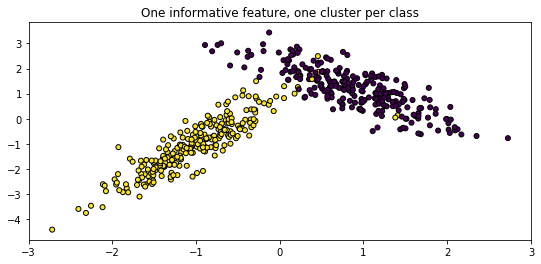

In [423]:
plt.figure(figsize=(9, 4))
plt.title("One informative feature, one cluster per class")
X, y = make_classification(n_samples=500, n_features=2, n_classes=2,
                               n_redundant=0, n_informative=2, n_clusters_per_class=1)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

In [425]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [662]:
from functools import reduce

np.seterr(all='raise')

class Layer:
    
    def __init__(self, name=1, inputs=1, outputs=1, activation='sigmoid'):
        self._name = name
        sw = 1 # np.sqrt(2 / (outputs + inputs))
        self.W = np.round(np.random.uniform(-1, 1, (outputs, inputs)), 10) * sw
        self.B = np.round(np.random.uniform(0, 1, (outputs, 1)), 10) * sw
        self.A = np.zeros((self.W.shape[0], inputs))
        
        if activation == 'sigmoid':
            self._activation = self._sigmoid
        else:
            self._activation = self._relu
    
    def __str__(self):
        return f'Layer: {self._name}'
    
    def __repr__(self):
        return f'Layer: {self._name}'
    
    def _sigmoid(self, Z, deriv=False):
        if deriv == True:
            return Z * (1 - Z)
        K = np.clip(Z, -1, 1)
        return np.nan_to_num(1 / (1 + np.exp(-K))) + 1e-7
    
    def _relu(self, Z, deriv=False):
        if deriv == True:
            return np.where(Z <= 0, 0, 1)
        return np.maximum(0, Z)

    def forward(self, Z):
        self.A = self._activation(np.dot(self.W, Z) + self.B)
        return self.A
    
    def E_grad(self, E):
        return E * self._activation(self.A, deriv=True)

    
class MultiLayerPerceptron:
    
    def __init__(self, layers, X, y):
        self._layers = layers
        self._X = X
        self._y = np.array([y])
    
        self._data_size = (1 / self._X.shape[0])
        self._total_layers = len(layers)
    
    def batch(self, input_list, batch_size):
        def reducer(cumulator, item):
            if len(cumulator[-1]) < batch_size:
                cumulator[-1].append(item)
                return cumulator
            else:
                cumulator.append([item])
                return cumulator
        return reduce(reducer, input_list, [[]])
    
    def _mse(self, Z):
        return np.sum(Z**2)
    
    def train(self, epochs=1500, lr=1e-3):
        error_step = []
        total_expected_error = 0
        for epoch in range(epochs):
            S = self._X.copy()
            # Mini Batch
            for Zy in self.batch(S, 2):
                # Forward
                Z = self.predict(Zy)

                # Backward
                E = self._y - Z  # error
                
                # backprop
                E_prev = E.copy()
                last_layer = self._layers[-1]
                grad = self._data_size * last_layer.E_grad(E_prev)
                last_layer.W += lr * np.dot(grad, self._layers[-2].A.T) / 100
                last_layer.B += lr * np.sum(grad) / 100
                
                # Hidden Layers
                k = len(self._layers)-2
                for layer in reversed(self._layers[1:len(self._layers)-1]):
                    E_prev = np.dot(last_layer.W.T, E_prev)
                    last_layer = layer
                    grad = self._data_size *last_layer.E_grad(E_prev)
                    last_layer.W += lr * np.dot(grad, self._layers[(k-1)].A.T) / 100
                    last_layer.B += lr * np.sum(grad) / 100
                    k -= 1

                E_prev = np.dot(last_layer.W.T, E_prev)
                last_layer = self._layers[0]
                grad = self._data_size *last_layer.E_grad(E_prev)
                last_layer.W += lr * np.dot(grad, self._X.T) / 100
                last_layer.B += lr * np.sum(grad) / 100
            
            # Cost
            total_error = self._mse(E)
            if np.abs(total_expected_error-total_error) < 1e-15:
                return np.array(error_step)
            total_expected_error = total_error
            error_step.append(total_error)    
        return np.array(error_step)
        
    def predict(self, Z):
        for layer in self._layers:
            Z = layer.forward(Z)
        return Z

Acurácia: 53.33%
Acurácia: 97.33%
Acurácia: 94.67%
Acurácia: 97.33%
Acurácia: 98.0%


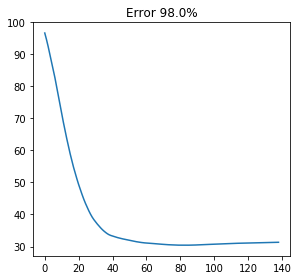

In [672]:
final_error = None
better_acc = 0

for _ in range(5):
    layers = (
        Layer(1, inputs=2, outputs=4, activation='relu'),
        Layer(2, inputs=4, outputs=8, activation='relu'), 
        Layer(3, inputs=8, outputs=16, activation='relu'), 
        Layer(4, inputs=16, outputs=8, activation='relu'), 
        Layer(5, inputs=8, outputs=4, activation='relu'), 
        Layer(6, inputs=4, outputs=1), 
    )
    
    md = MultiLayerPerceptron(layers, X_train.copy().T, y_train.copy().T)
    error = md.train()
    predYm = np.where(md.predict(X_test.copy().T) > .5, 1, 0)
    acc = np.round((np.sum(predYm == y_test) / len(y_test)) * 100, 2)
    if acc > better_acc:
        final_error = error
        better_acc = acc
    print(f'Acurácia: {acc}%')

if len(final_error):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'Error {better_acc}%')
    plt.plot(range(len(final_error)), final_error)
    plt.tight_layout()
    plt.show()

In [673]:
for _ in range(5):
    clf = MLPClassifier(max_iter=1500, tol=1e-3, alpha=1e-3)
    clf.fit(X_train, y_train)
    print(f'Acurácia: {np.round(clf.score(X_test, y_test) * 100, 2)}%')

Acurácia: 98.0%
Acurácia: 98.0%
Acurácia: 98.0%
Acurácia: 97.33%
Acurácia: 98.0%
